# **Feature Engineering Notebook**

## Objectives

* Engineer features for further analysis and model development.
* Apply numerical and categorical transformations to improve data quality and model performance.
* Select important features using Smart Correlated Selection.

## Inputs

* Cleaned COVID-19 Dataset: The cleaned and processed dataset from the Data Cleaning Notebook, saved as outputs/datasets/cleaned/TrainSetCleaned.csv and outputs/datasets/cleaned/TestSetCleaned.csv.

## Outputs

* Engineered Dataset: outputs/datasets/engineered/TrainSetEngineered.csv and outputs/datasets/engineered/TestSetEngineered.csv.

## Additional Comments

* This notebook focuses on transforming features to enhance model performance.
* The transformations include encoding categorical variables, transforming numerical variables, and selecting the most relevant features.

---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/milestone-covid-19-study/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/milestone-covid-19-study'

---

## Load Cleaned Data

Train Set

In [4]:
import pandas as pd
train_set_path = "outputs/datasets/cleaned/TrainSetCleaned.csv"
TrainSet = pd.read_csv(train_set_path)
print(TrainSet.head(3))

    SEX INTUBED PNEUMONIA  AGE DIABETES COPD ASTHMA INMSUPR HIPERTENSION  \
0  Male      No       Yes   47      Yes   No     No      No           No   
1  Male      No       Yes   35       No   No     No      No           No   
2  Male      No       Yes   37      Yes   No     No      No           No   

  OTHER_DISEASE CARDIOVASCULAR OBESITY RENAL_CHRONIC TOBACCO  ICU DIED  
0            No             No     Yes            No      No   No   No  
1            No             No      No            No      No  Yes   No  
2            No             No     Yes            No      No   No  Yes  


Test Set

In [5]:
test_set_path = 'outputs/datasets/cleaned/TestSetCleaned.csv'
TestSet = pd.read_csv(test_set_path)
print(TestSet.head(3))

      SEX INTUBED PNEUMONIA  AGE DIABETES COPD ASTHMA INMSUPR HIPERTENSION  \
0  Female      No       Yes   56       No   No     No      No           No   
1  Female      No        No   72       No   No     No      No           No   
2  Female      No        No   47      Yes   No     No     Yes          Yes   

  OTHER_DISEASE CARDIOVASCULAR OBESITY RENAL_CHRONIC TOBACCO  ICU DIED  
0            No             No      No            No      No   No   No  
1           Yes             No     Yes            No      No   No  Yes  
2            No             No     Yes            No      No  Yes  Yes  


## Data Exploration

In [6]:
from ydata_profiling import ProfileReport

pandas_report = ProfileReport(df=TrainSet, minimal=True)
pandas_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Feature Engineering

### Custom Function

In [7]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')


def FeatureEngineeringAnalysis(df, analysis_type=None):
    """
    - used for quick feature engineering on numerical and categorical variables
    to decide which transformation can better transform the distribution shape
    - Once transformed, use a reporting tool, like ydata-profiling, to evaluate distributions
    """
    check_missing_values(df)
    allowed_types = ['numerical', 'ordinal_encoder', 'outlier_winsorizer']
    check_user_entry_on_analysis_type(analysis_type, allowed_types)
    list_column_transformers = define_list_column_transformers(analysis_type)

    # Loop in each variable and engineer the data according to the analysis type
    df_feat_eng = pd.DataFrame([])
    for column in df.columns:
        # create additional columns (column_method) to apply the methods
        df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
        for method in list_column_transformers:
            df_feat_eng[f"{column}_{method}"] = df[column]

        # Apply transformers in respective column_transformers
        df_feat_eng, list_applied_transformers = apply_transformers(
            analysis_type, df_feat_eng, column)

        # For each variable, assess how the transformations perform
        transformer_evaluation(
            column, list_applied_transformers, analysis_type, df_feat_eng)

    return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
    """ Check analysis type """
    if analysis_type is None:
        raise SystemExit(
            f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
    if analysis_type not in allowed_types:
        raise SystemExit(
            f"analysis_type argument should be one of these options: {allowed_types}")


def check_missing_values(df):
    if df.isna().sum().sum() != 0:
        raise SystemExit(
            f"There is a missing value in your dataset. Please handle that before getting into feature engineering.")


def define_list_column_transformers(analysis_type):
    """ Set suffix columns according to analysis_type"""
    if analysis_type == 'numerical':
        list_column_transformers = [
            "log_e", "log_10", "reciprocal", "power", "box_cox", "yeo_johnson"]

    elif analysis_type == 'ordinal_encoder':
        list_column_transformers = ["ordinal_encoder"]

    elif analysis_type == 'outlier_winsorizer':
        list_column_transformers = ['iqr']

    return list_column_transformers


def apply_transformers(analysis_type, df_feat_eng, column):
    for col in df_feat_eng.select_dtypes(include='category').columns:
        df_feat_eng[col] = df_feat_eng[col].astype('object')

    if analysis_type == 'numerical':
        df_feat_eng, list_applied_transformers = FeatEngineering_Numerical(
            df_feat_eng, column)

    elif analysis_type == 'outlier_winsorizer':
        df_feat_eng, list_applied_transformers = FeatEngineering_OutlierWinsorizer(
            df_feat_eng, column)

    elif analysis_type == 'ordinal_encoder':
        df_feat_eng, list_applied_transformers = FeatEngineering_CategoricalEncoder(
            df_feat_eng, column)

    return df_feat_eng, list_applied_transformers


def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
    # For each variable, assess how the transformations perform
    print(f"* Variable Analyzed: {column}")
    print(f"* Applied transformation: {list_applied_transformers} \n")
    for col in [column] + list_applied_transformers:

        if analysis_type != 'ordinal_encoder':
            DiagnosticPlots_Numerical(df_feat_eng, col)

        else:
            if col == column:
                DiagnosticPlots_Categories(df_feat_eng, col)
            else:
                DiagnosticPlots_Numerical(df_feat_eng, col)

        print("\n")


def DiagnosticPlots_Categories(df_feat_eng, col):
    plt.figure(figsize=(4, 3))
    sns.countplot(data=df_feat_eng, x=col, palette=[
                  '#432371'], order=df_feat_eng[col].value_counts().index)
    plt.xticks(rotation=90)
    plt.suptitle(f"{col}", fontsize=30, y=1.05)
    plt.show()
    print("\n")


def DiagnosticPlots_Numerical(df, variable):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    sns.histplot(data=df, x=variable, kde=True, element="step", ax=axes[0])
    stats.probplot(df[variable], dist="norm", plot=axes[1])
    sns.boxplot(x=df[variable], ax=axes[2])

    axes[0].set_title('Histogram')
    axes[1].set_title('QQ Plot')
    axes[2].set_title('Boxplot')
    fig.suptitle(f"{variable}", fontsize=30, y=1.05)
    plt.tight_layout()
    plt.show()


def FeatEngineering_CategoricalEncoder(df_feat_eng, column):
    list_methods_worked = []
    try:
        encoder = OrdinalEncoder(encoding_method='arbitrary', variables=[
                                 f"{column}_ordinal_encoder"])
        df_feat_eng = encoder.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_ordinal_encoder")

    except Exception:
        df_feat_eng.drop([f"{column}_ordinal_encoder"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng, column):
    list_methods_worked = []

    # Winsorizer iqr
    try:
        disc = Winsorizer(
            capping_method='iqr', tail='both', fold=1.5, variables=[f"{column}_iqr"])
        df_feat_eng = disc.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_iqr")
    except Exception:
        df_feat_eng.drop([f"{column}_iqr"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_Numerical(df_feat_eng, column):
    list_methods_worked = []

    # LogTransformer base e
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_e"])
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_e")
    except Exception:
        df_feat_eng.drop([f"{column}_log_e"], axis=1, inplace=True)

    # LogTransformer base 10
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_10"], base='10')
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_10")
    except Exception:
        df_feat_eng.drop([f"{column}_log_10"], axis=1, inplace=True)

    # ReciprocalTransformer
    try:
        rt = vt.ReciprocalTransformer(variables=[f"{column}_reciprocal"])
        df_feat_eng = rt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_reciprocal")
    except Exception:
        df_feat_eng.drop([f"{column}_reciprocal"], axis=1, inplace=True)

    # PowerTransformer
    try:
        pt = vt.PowerTransformer(variables=[f"{column}_power"])
        df_feat_eng = pt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_power")
    except Exception:
        df_feat_eng.drop([f"{column}_power"], axis=1, inplace=True)

    # BoxCoxTransformer
    try:
        bct = vt.BoxCoxTransformer(variables=[f"{column}_box_cox"])
        df_feat_eng = bct.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_box_cox")
    except Exception:
        df_feat_eng.drop([f"{column}_box_cox"], axis=1, inplace=True)

    # YeoJohnsonTransformer
    try:
        yjt = vt.YeoJohnsonTransformer(variables=[f"{column}_yeo_johnson"])
        df_feat_eng = yjt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_yeo_johnson")
    except Exception:
        df_feat_eng.drop([f"{column}_yeo_johnson"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked

## Feature Engineering Spreadsheet Summary

### Dealing with Feature Engineering

#### Categorical Encoding - Ordinal: replaces categories with ordinal numbers

* Step 1: Select variables

In [8]:
variables_engineering = ['SEX', 'INTUBED', 'PNEUMONIA', 'DIABETES', 'COPD', 'ASTHMA', 
                         'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 
                         'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 'ICU']
variables_engineering

['SEX',
 'INTUBED',
 'PNEUMONIA',
 'DIABETES',
 'COPD',
 'ASTHMA',
 'INMSUPR',
 'HIPERTENSION',
 'OTHER_DISEASE',
 'CARDIOVASCULAR',
 'OBESITY',
 'RENAL_CHRONIC',
 'TOBACCO',
 'ICU']

* Step 2: Create a separate DataFrame, with your variables

In [9]:
df_engineering = TrainSet[variables_engineering].copy()
df_engineering.head(3)

,SEX,INTUBED,PNEUMONIA,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,ICU
0,Male,No,Yes,Yes,No,No,No,No,No,No,Yes,No,No,No
1,Male,No,Yes,No,No,No,No,No,No,No,No,No,No,Yes
2,Male,No,Yes,Yes,No,No,No,No,No,No,Yes,No,No,No


* Step 3: Create engineered variabless by applying the transformations, assess engineered variables distribution and select the most suitable method for each variable.

* Variable Analyzed: SEX
* Applied transformation: ['SEX_ordinal_encoder'] 



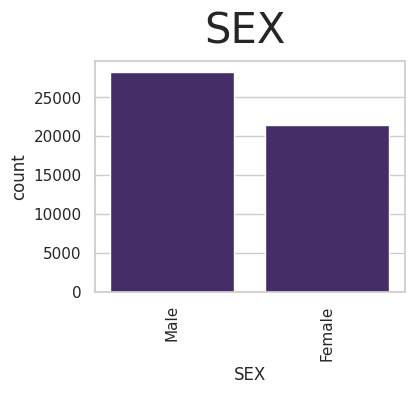

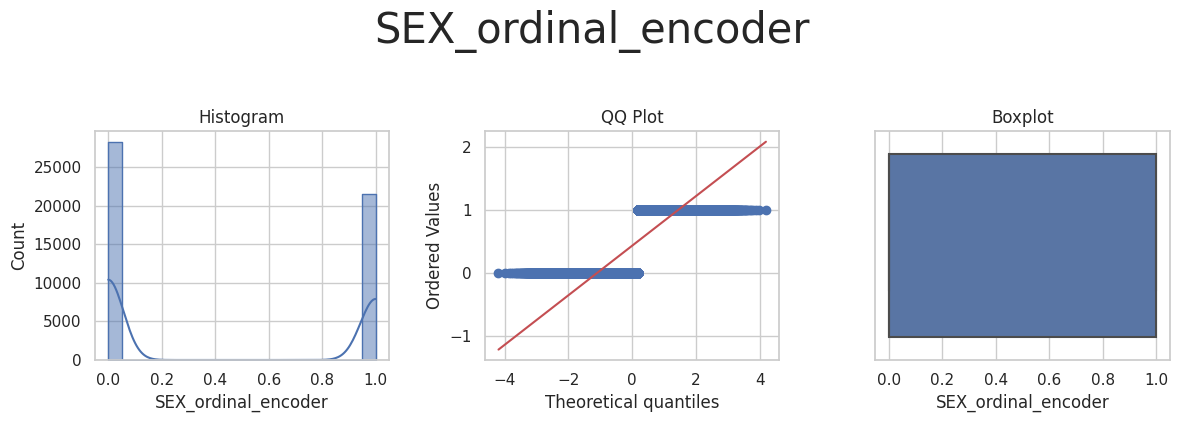



* Variable Analyzed: INTUBED
* Applied transformation: ['INTUBED_ordinal_encoder'] 



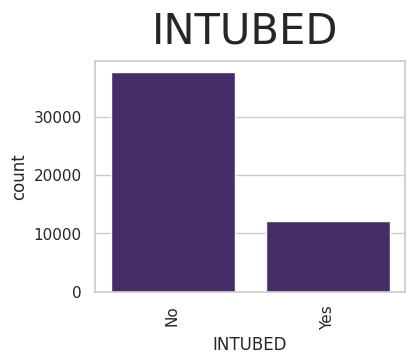

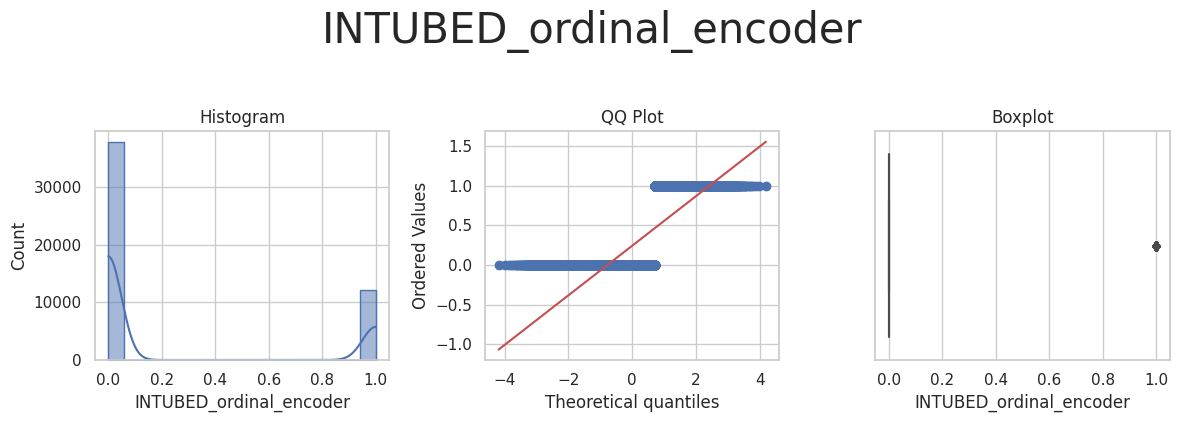



* Variable Analyzed: PNEUMONIA
* Applied transformation: ['PNEUMONIA_ordinal_encoder'] 



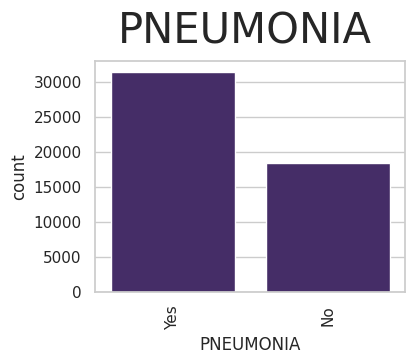

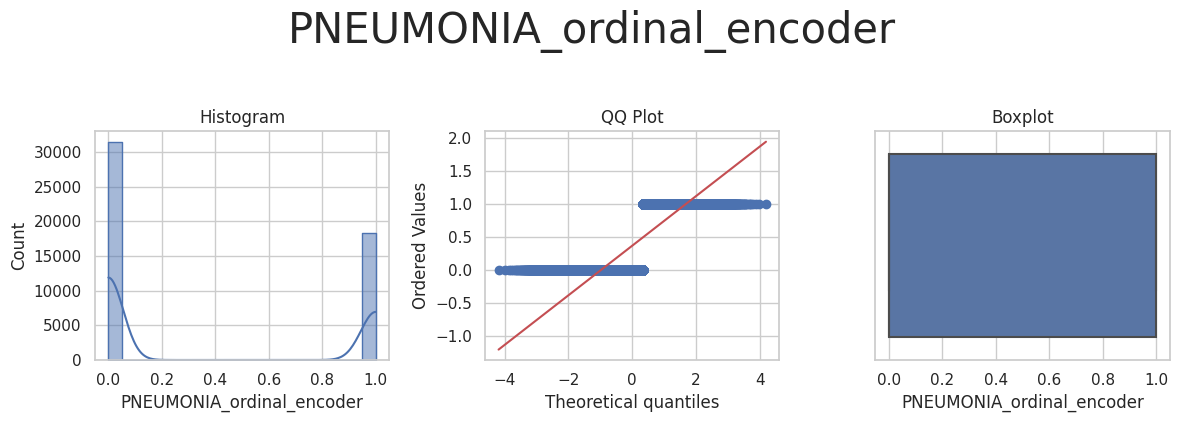



* Variable Analyzed: DIABETES
* Applied transformation: ['DIABETES_ordinal_encoder'] 



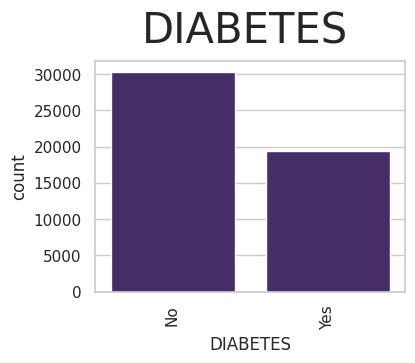

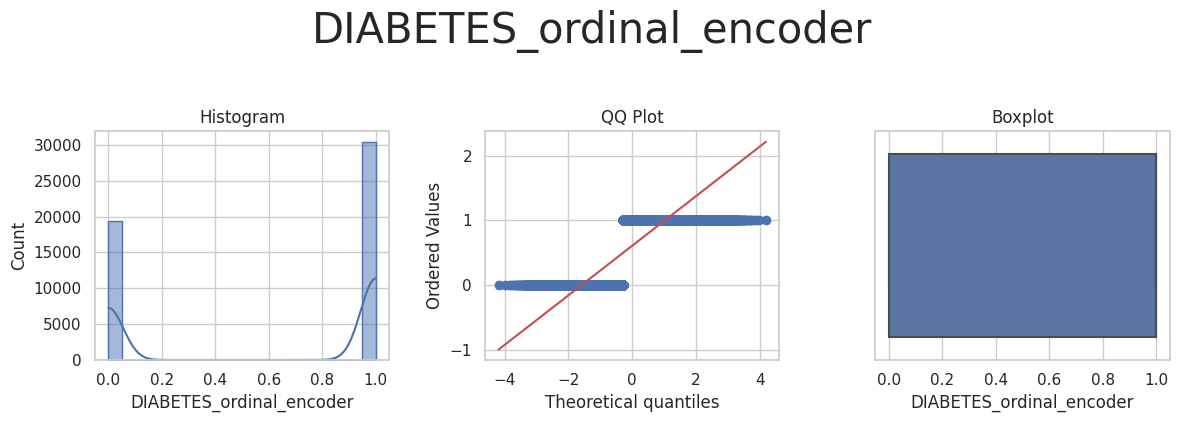



* Variable Analyzed: COPD
* Applied transformation: ['COPD_ordinal_encoder'] 



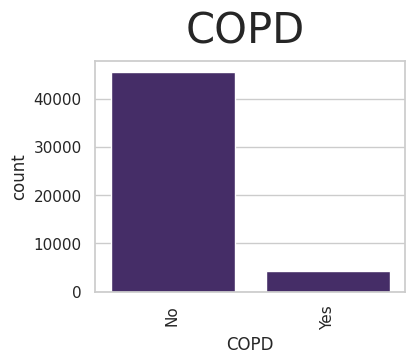

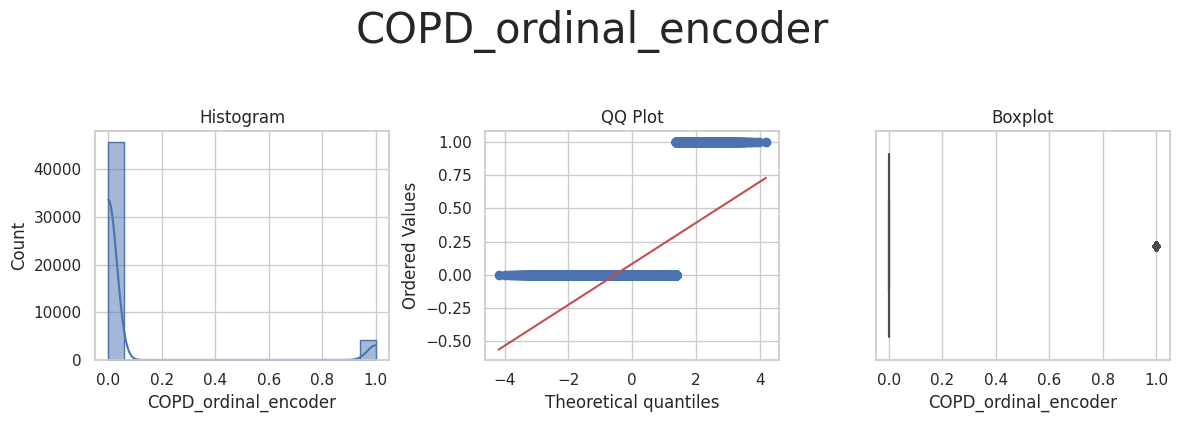



* Variable Analyzed: ASTHMA
* Applied transformation: ['ASTHMA_ordinal_encoder'] 



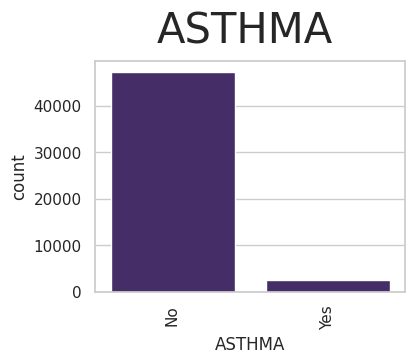

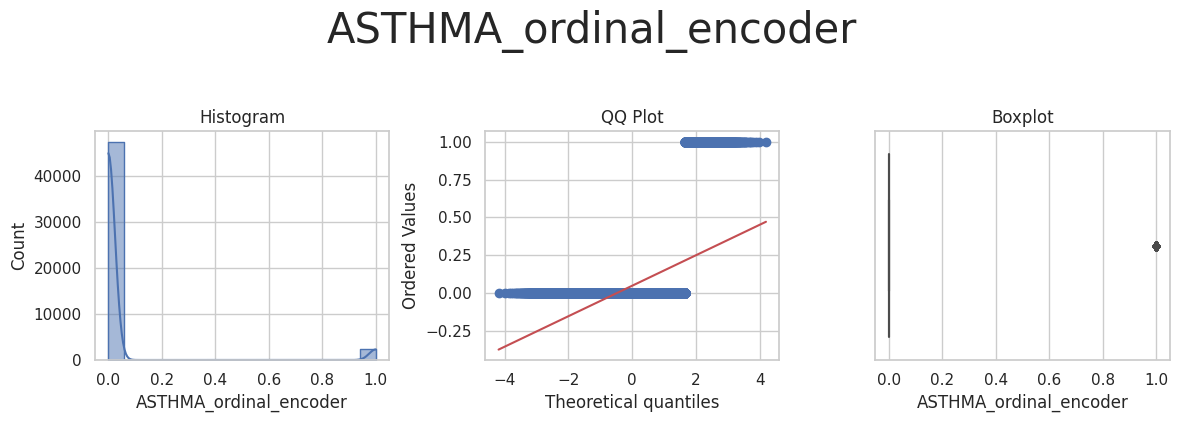



* Variable Analyzed: INMSUPR
* Applied transformation: ['INMSUPR_ordinal_encoder'] 



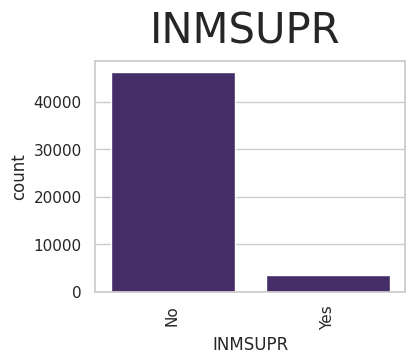

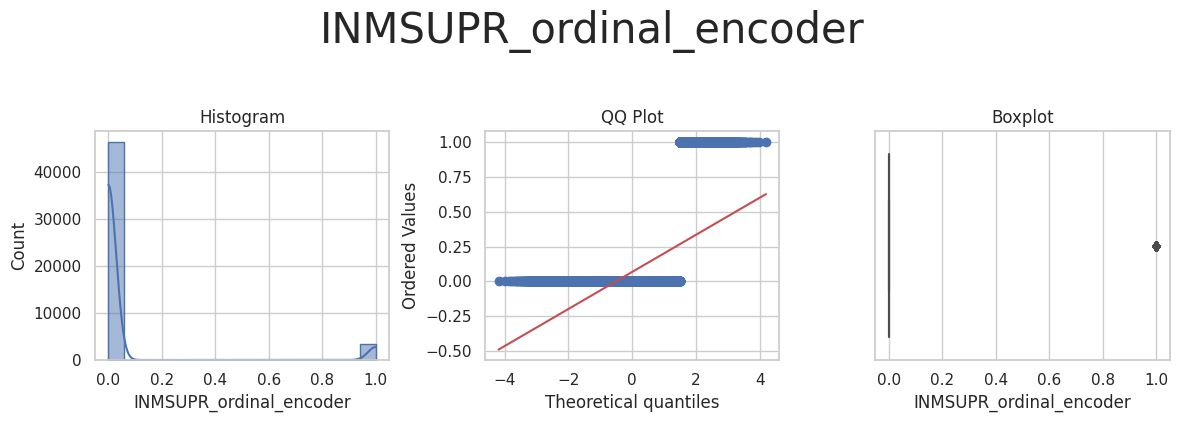



* Variable Analyzed: HIPERTENSION
* Applied transformation: ['HIPERTENSION_ordinal_encoder'] 



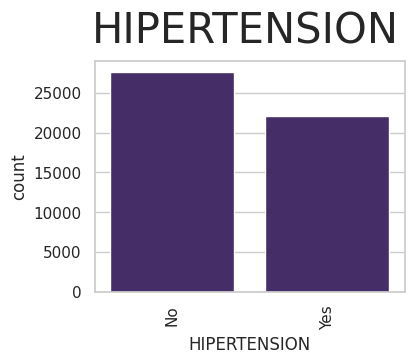

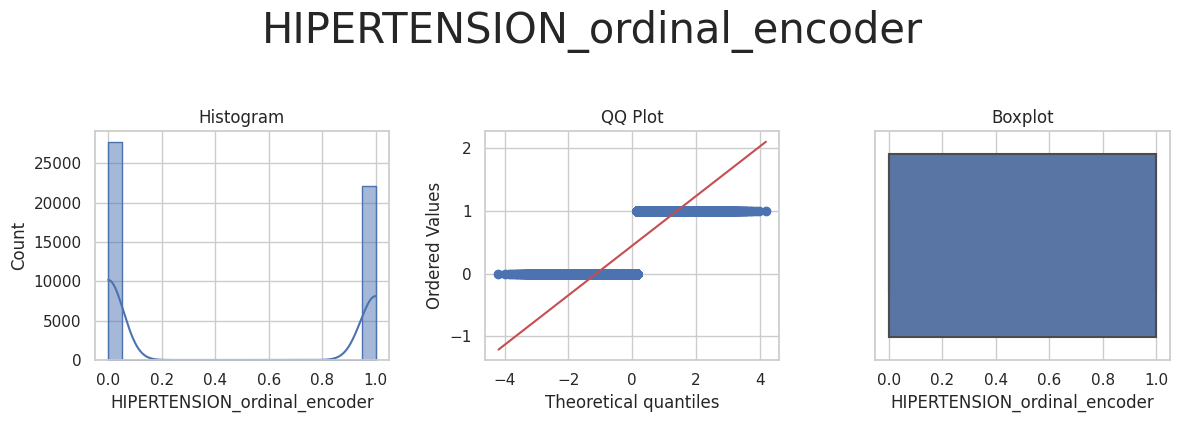



* Variable Analyzed: OTHER_DISEASE
* Applied transformation: ['OTHER_DISEASE_ordinal_encoder'] 



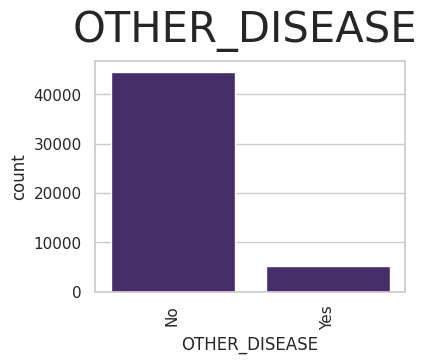

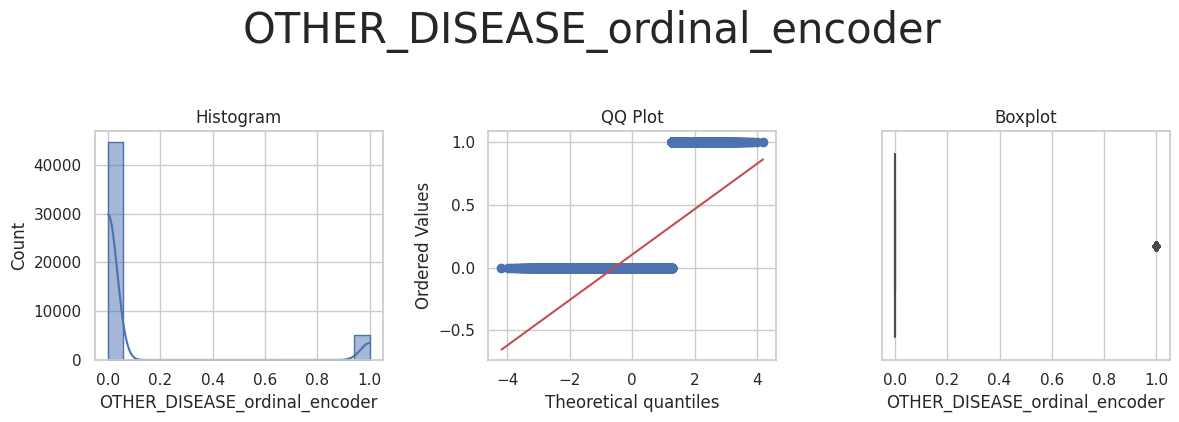



* Variable Analyzed: CARDIOVASCULAR
* Applied transformation: ['CARDIOVASCULAR_ordinal_encoder'] 



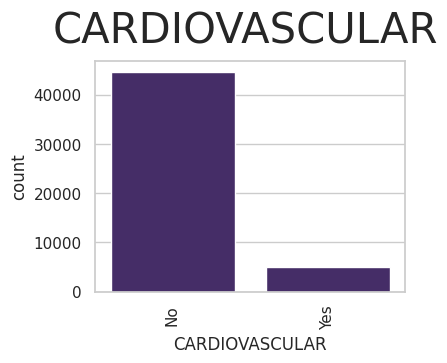

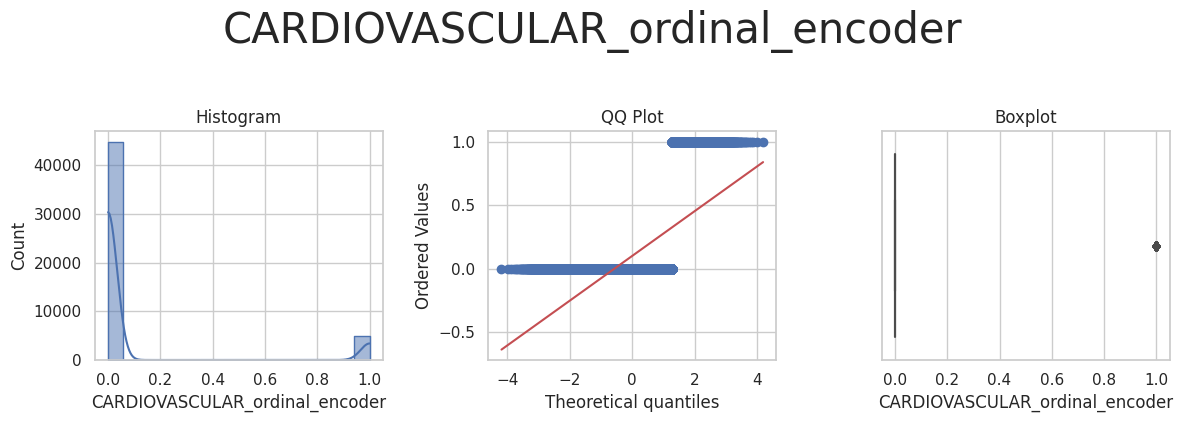



* Variable Analyzed: OBESITY
* Applied transformation: ['OBESITY_ordinal_encoder'] 



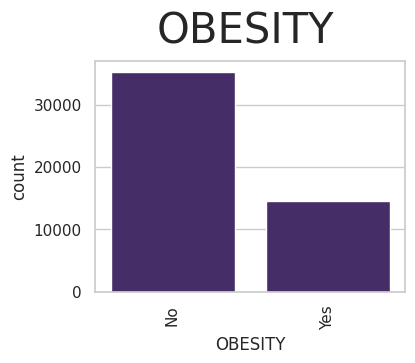

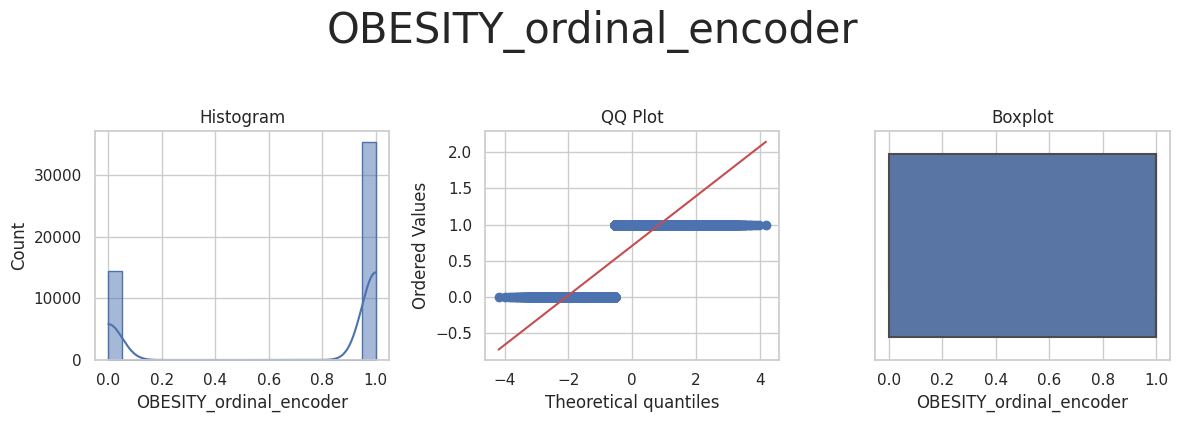



* Variable Analyzed: RENAL_CHRONIC
* Applied transformation: ['RENAL_CHRONIC_ordinal_encoder'] 



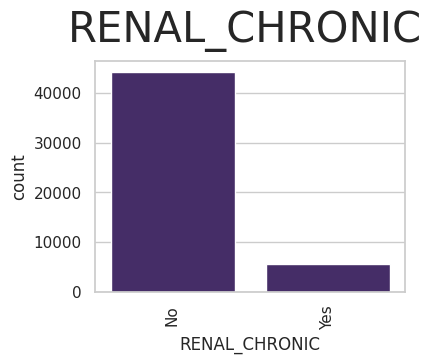

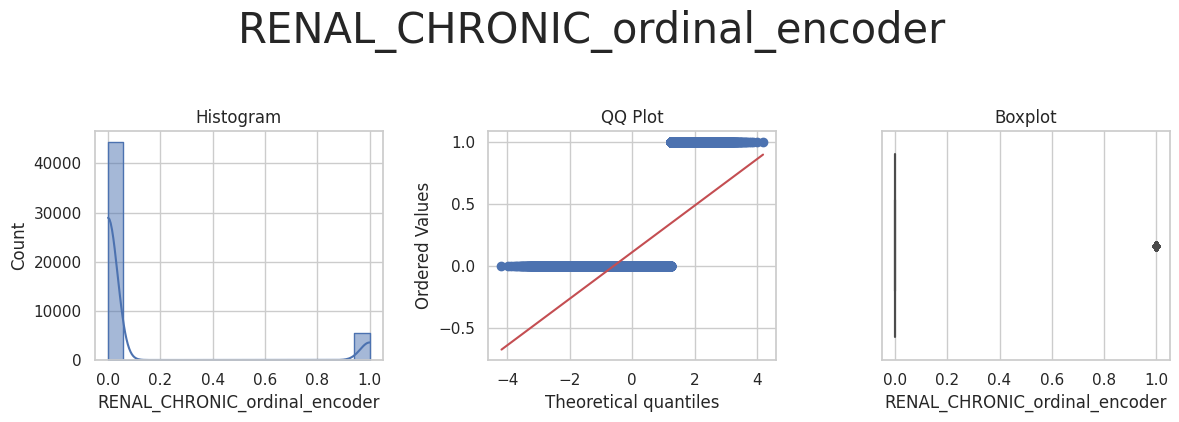



* Variable Analyzed: TOBACCO
* Applied transformation: ['TOBACCO_ordinal_encoder'] 



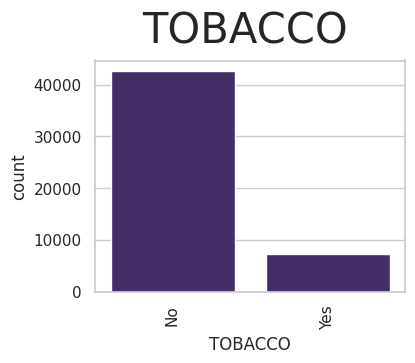

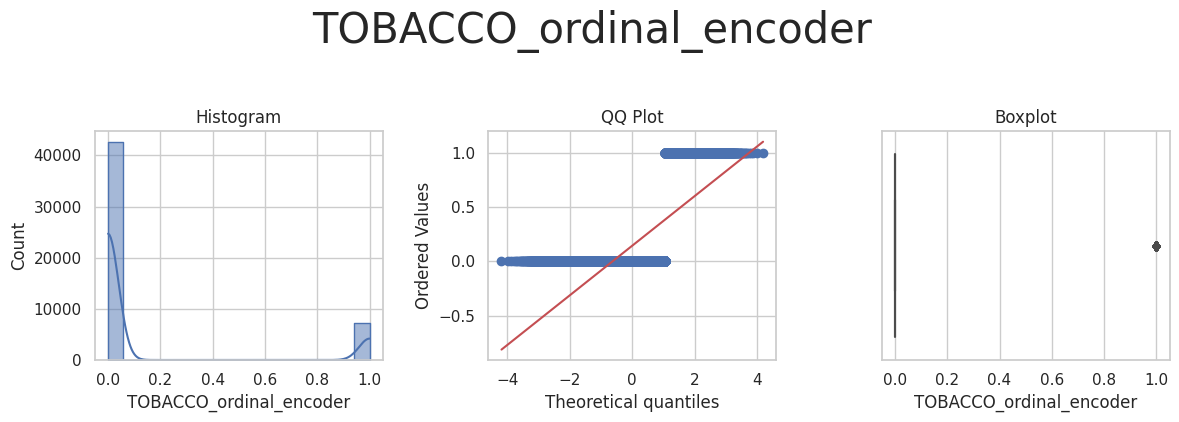



* Variable Analyzed: ICU
* Applied transformation: ['ICU_ordinal_encoder'] 



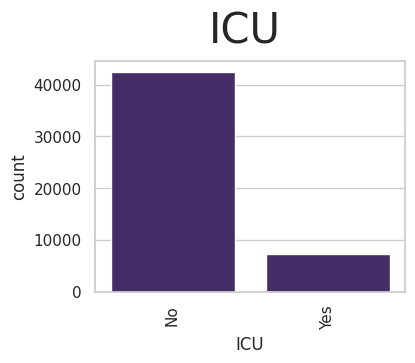

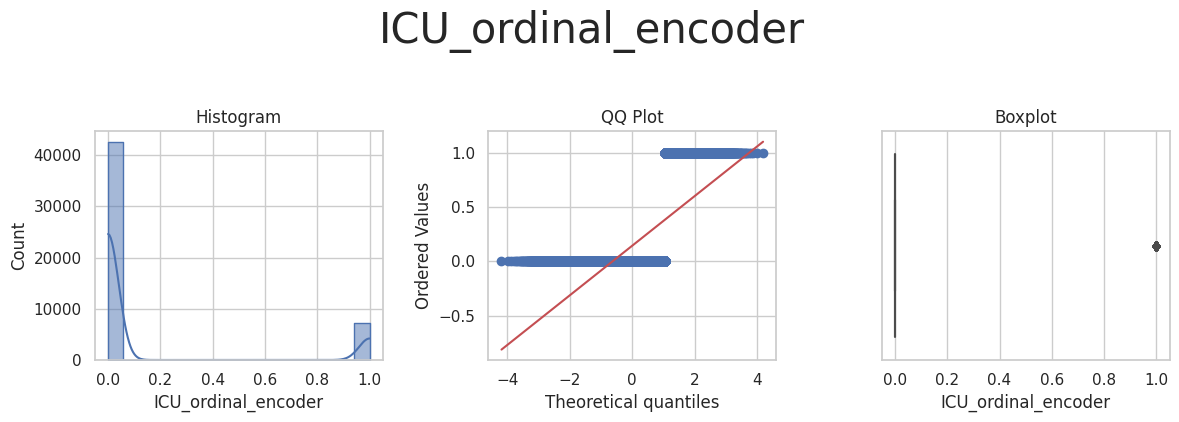

In [10]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='ordinal_encoder')

* Step 4 - Apply the selected transformation to the Train and Test set

In [11]:
encoder = OrdinalEncoder(encoding_method='arbitrary', variables=variables_engineering)
TrainSet = encoder.fit_transform(TrainSet)
TestSet = encoder.transform(TestSet)

print("* Categorical encoding - ordinal transformation done!")
print(TrainSet.head(3))
print(TestSet.head(3))

* Categorical encoding - ordinal transformation done!
   SEX  INTUBED  PNEUMONIA  AGE  DIABETES  COPD  ASTHMA  INMSUPR  \
0    0        0          0   47         0     0       0        0   
1    0        0          0   35         1     0       0        0   
2    0        0          0   37         0     0       0        0   

   HIPERTENSION  OTHER_DISEASE  CARDIOVASCULAR  OBESITY  RENAL_CHRONIC  \
0             0              0               0        0              0   
1             0              0               0        1              0   
2             0              0               0        0              0   

   TOBACCO  ICU DIED  
0        0    0   No  
1        0    1   No  
2        0    0  Yes  
   SEX  INTUBED  PNEUMONIA  AGE  DIABETES  COPD  ASTHMA  INMSUPR  \
0    1        0          0   56         1     0       0        0   
1    1        0          1   72         1     0       0        0   
2    1        0          1   47         0     0       0        1   

   HIPERTEN

### Numerical Transformation

* Step 1: Select variable

In [12]:
variables_engineering = ['AGE']
variables_engineering

['AGE']

* Step 2: Create a separate DataFrame, with your variable

In [13]:
df_engineering = TrainSet[variables_engineering].copy()
df_engineering.head(3)

,AGE
0,47
1,35
2,37


* Step 3: Create engineered variables by applying the transformation, assess engineered variables distribution and select the most suitable method

* Variable Analyzed: AGE
* Applied transformation: ['AGE_power', 'AGE_yeo_johnson'] 



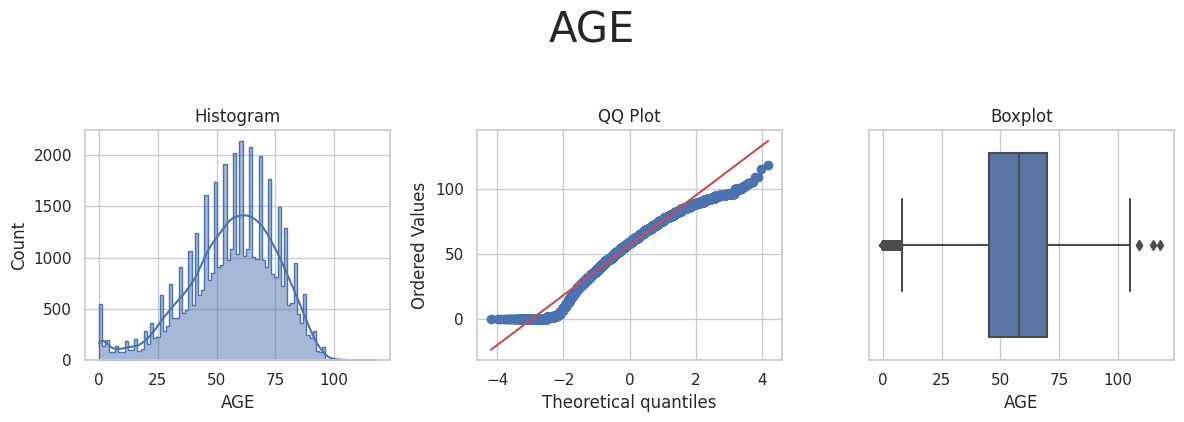

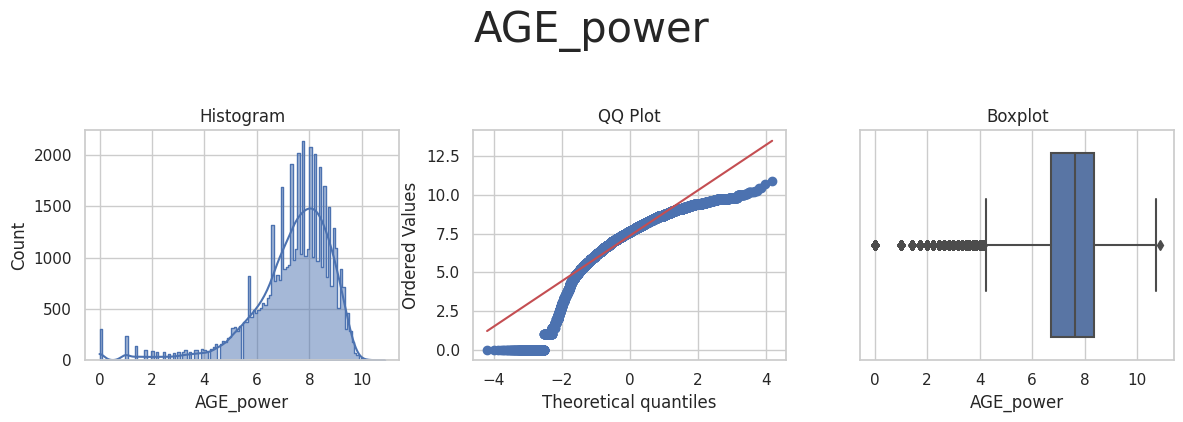

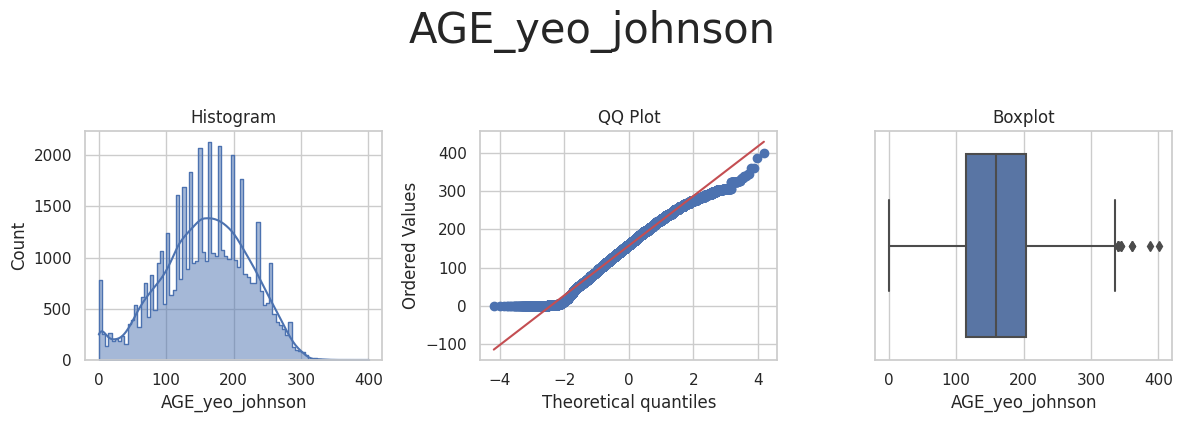

In [14]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='numerical')

* Step 4 - Apply the selected transformation to the Train and Test set

In [15]:
try:
    os.makedirs('outputs/datasets/engineered', exist_ok=True)
except Exception as e:
    print(e)

TrainSet.to_csv("outputs/datasets/engineered/TrainSetEngineered.csv", index=False)
TestSet.to_csv("outputs/datasets/engineered/TestSetEngineered.csv", index=False)

print("No effective numerical transformation found. Original datasets saved as engineered datasets.")
print(TrainSet.head(3))
print(TestSet.head(3))

No effective numerical transformation found. Original datasets saved as engineered datasets.
   SEX  INTUBED  PNEUMONIA  AGE  DIABETES  COPD  ASTHMA  INMSUPR  \
0    0        0          0   47         0     0       0        0   
1    0        0          0   35         1     0       0        0   
2    0        0          0   37         0     0       0        0   

   HIPERTENSION  OTHER_DISEASE  CARDIOVASCULAR  OBESITY  RENAL_CHRONIC  \
0             0              0               0        0              0   
1             0              0               0        1              0   
2             0              0               0        0              0   

   TOBACCO  ICU DIED  
0        0    0   No  
1        0    1   No  
2        0    0  Yes  
   SEX  INTUBED  PNEUMONIA  AGE  DIABETES  COPD  ASTHMA  INMSUPR  \
0    1        0          0   56         1     0       0        0   
1    1        0          1   72         1     0       0        0   
2    1        0          1   47         0

### SmartCorrelatedSelection Variables

* Step 1 - Create a separate DataFrame, with your variables

In [16]:
df_engineering = TrainSet.copy()
print(df_engineering.head(3))

   SEX  INTUBED  PNEUMONIA  AGE  DIABETES  COPD  ASTHMA  INMSUPR  \
0    0        0          0   47         0     0       0        0   
1    0        0          0   35         1     0       0        0   
2    0        0          0   37         0     0       0        0   

   HIPERTENSION  OTHER_DISEASE  CARDIOVASCULAR  OBESITY  RENAL_CHRONIC  \
0             0              0               0        0              0   
1             0              0               0        1              0   
2             0              0               0        0              0   

   TOBACCO  ICU DIED  
0        0    0   No  
1        0    1   No  
2        0    0  Yes  


* Step 2 - Create engineered variabless applying the transformations

In [17]:
from feature_engine.selection import SmartCorrelatedSelection
corr_sel = SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")

corr_sel.fit_transform(df_engineering)
print(corr_sel.correlated_feature_sets_)
print(corr_sel.features_to_drop_)

[]
[]


# Conclusion and Next Steps

### Conclusion
- Categorical features were encoded using ordinal encoding.
- Numerical transformations were applied to the AGE column, but no effective transformations were found.
- SmartCorrelatedSelection was applied, and no highly correlated features were found to be dropped.

### Next Steps
- Begin model development using the engineered dataset.
- Evaluate models and iterate on feature engineering.